# The Best Format to Save Pandas Data

In [ ]:
# Based on Ilia Zaitsev
# https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d

In [1]:
from collections import defaultdict
import os

In [2]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

In [3]:
from utils import Timer, MemoryTracker, GC, NotebookStyle

In [4]:
style = NotebookStyle()
style.override({'grid.color': 'lightgray'})

## Random Dataset

In [5]:
def generate_dataset(n_rows, num_count, cat_count, max_nan=0.1, max_cat_size=100):
    """Randomly generate datasets with numerical and categorical features.
    
    The numerical features are taken from the normal distribution X ~ N(0, 1).
    The categorical features are generated as random uuid4 strings with 
    cardinality C where 2 <= C <= max_cat_size.
    
    Also, a max_nan proportion of both numerical and categorical features is replaces
    with NaN values.
    """
    dataset, types = {}, {}
    
    def generate_categories():
        from uuid import uuid4
        category_size = np.random.randint(2, max_cat_size)
        return [str(uuid4()) for _ in range(category_size)]
    
    for col in range(num_count):
        name = f'n{col}'
        values = np.random.normal(0, 1, n_rows)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'float32'
        
    for col in range(cat_count):
        name = f'c{col}'
        cats = generate_categories()
        values = np.array(np.random.choice(cats, n_rows, replace=True), dtype=object)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'object'
    
    return pd.DataFrame(dataset), types

## Benchmarking

In [6]:
def size_of(filename, unit=1024**2):
    return round(os.stat(filename).st_size / unit, 2)

In [7]:
def get_save_load(df, fmt):
    save = getattr(df, f'to_{fmt}')
    load = feather.read_dataframe if fmt == 'feather' else getattr(pd, f'read_{fmt}')
    return save, load

In [31]:
def benchmark(list_of_formats, data_size=50_000, n_num=25, n_cat=25, n_rounds=20,
              as_category=False):
    """Runs dataset saving/loading benchamrk using formts from the list_of_formats.
    
    Each round a new random dataset is generated with data_size observations. 
    The measurements for each of the rounds are concatenated together and returned
    as a single data frame.
    
    Parameters:
        list_of_formats: A list of tuples in the format (<format_name>, [<params_dict>]). 
            The <format_name> should be one of the pandas supported formats.
        data_size: A number of samples in the generated dataset.
        n_num: A number of numerical columns in the generated dataset.
        n_cat: A number of categorical columns in the generated dataset.
        n_rounds: A number of randomly generated datasets to test the formats.
        as_category: If True, then categorical columns will be converted into 
            pandas.Category type before saving.
            
    """
    runs = []
    
    for i in range(n_rounds):
        print(f'Benchmarking round #{i + 1:d}')
        print('\tgenerating dataset...', end=', ')
        dataset, _ = generate_dataset(data_size, n_num, n_cat)
        
        if as_category:
            print('\tconverting categorical columns into pandas.Category')
            cat_cols = dataset.select_dtypes(include=object).columns
            dataset[cat_cols] = dataset[cat_cols].fillna('none').astype('category')
        
        benchmark = []
        
        for case in list_of_formats:
            fmt, params = case if len(case) == 2 else (case[0], {})
            
            with GC():
                print(fmt, end=', ')
                filename = f'random.{fmt}'
                if fmt=='excel':
                    filename = f'random'+'.xlsx'
                if fmt=='csv':
                    try:
                        if list(params.values())[0] == 'gzip':
                            filename = f'random'+'.csv.gz'
                        else: 
                            filename = filename
                    except IndexError:
                        filename= filename
                    try:
                        if list(params.values())[0] == 'zip':
                            filename = f'random'+'.csv.zip'
                        else: 
                            filename = filename
                    except IndexError:
                        filename= filename

                save, load = get_save_load(dataset, fmt)
                results = defaultdict(int)
                
                fmt_myg = fmt
                if fmt=='csv':
                    try:
                        if list(params.values())[0] == 'gzip':
                            fmt_myg = 'csv_gz'
                        else:
                            fmt_myg = fmt_myg
                    except IndexError:
                        fmt_myg = fmt_myg
                    try:
                        if list(params.values())[0] == 'zip':
                            fmt_myg = 'csv_zip'
                        else:
                            fmt_myg = fmt_myg
                    except IndexError:
                        fmt_myg = fmt_myg

                results['format'] = fmt_myg
                results['filename'] = filename
                
                #with MemoryTracker() as tracker:
                with Timer() as timer:
                    save(filename, **params)
                results['size_mb'] = size_of(filename)
                #results['save_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['save_time'] = float(timer)
                
                #with MemoryTracker() as tracker:
                with Timer() as timer:
                    _ = load(filename)
                #results['load_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['load_time'] = float(timer)
                results['zeit'] = datetime.now().time()
                benchmark.append(results)
                
            run = pd.DataFrame(benchmark)
            run['run_no'] = i
            runs.append(run)
        
        print('...round finished')
    benchmark = pd.concat(runs, axis=0)
    benchmark.reset_index(inplace=True, drop=True)
    return benchmark

### CSV Baseline

### Categoricals As Strings

In [29]:
formats = [
    ('hdf', {'key': 'data', 'format': 'table'}),
    ('csv', {'compression': 'gzip'}),
    ('csv', {'compression': 'zip'}),
    ('csv', {'compression': None}),
    ('pickle',),
    ('feather',),
    ('xml',),
    ('json',),
    ('stata',),
    ('parquet', {'engine': 'pyarrow'})
]

In [28]:
del results

In [32]:
results = benchmark(formats, n_rounds=5, data_size=50000)

Benchmarking round #1
	generating dataset..., hdf, csv, csv, csv, pickle, feather, xml, json, stata, parquet, ...round finished
Benchmarking round #2
	generating dataset..., hdf, csv, csv, csv, pickle, feather, xml, json, stata, parquet, ...round finished
Benchmarking round #3
	generating dataset..., hdf, csv, csv, csv, pickle, feather, xml, json, stata, parquet, ...round finished
Benchmarking round #4
	generating dataset..., hdf, csv, csv, csv, pickle, feather, xml, json, stata, parquet, ...round finished
Benchmarking round #5
	generating dataset..., hdf, csv, csv, csv, pickle, feather, xml, json, stata, parquet, ...round finished


In [44]:
results.drop_duplicates(inplace=True)
results.reset_index(inplace=True)
results

,level_0,index,format,filename,size_mb,save_time,load_time,zeit,run_no
0,0,0,hdf,random.hdf,690.22,0.396549,0.279582,21:33:10.614689,0
1,1,2,csv_gz,random.csv.gz,26.75,3.078694,0.625938,21:33:14.414105,0
2,2,5,csv_zip,random.csv.zip,26.76,2.997551,0.526735,21:33:18.013124,0
3,3,9,csv,random.csv,64.44,1.290491,0.361972,21:33:19.743799,0
4,4,14,pickle,random.pickle,54.15,0.251205,0.088770,21:33:20.160968,0
5,5,20,feather,random.feather,18.75,0.079886,0.048180,21:33:20.365651,0
6,6,27,xml,random.xml,99.40,4.471569,6.255054,21:33:31.171499,0
7,7,35,json,random.json,78.35,0.297624,0.779527,21:33:32.407678,0
8,8,44,stata,random.stata,52.65,0.869928,0.473187,21:33:33.826640,0
9,9,54,parquet,random.parquet,12.41,0.211150,0.070479,21:33:34.189176,0


In [45]:
#results.to_feather('50000_cats_str.feather')
#results = feather.read_dataframe('50000_cats_str.feather')

In [46]:
avg = results.groupby('format').mean(numeric_only=True).reset_index().drop(columns=['run_no'])
avg

,format,level_0,index,size_mb,save_time,load_time
0,csv,23.0,119.0,64.586,1.325238,0.372992
1,csv_gz,21.0,112.0,26.310,3.144833,0.623245
2,csv_zip,22.0,115.0,26.318,3.053744,0.533767
3,feather,25.0,130.0,18.746,0.082477,0.049042
4,hdf,20.0,110.0,690.220,0.373205,0.296166
5,json,27.0,145.0,78.490,0.299026,0.824655
6,parquet,29.0,164.0,12.398,0.207222,0.067166
7,pickle,24.0,124.0,54.278,0.231909,0.088313
8,stata,28.0,154.0,52.650,0.866381,0.470522
9,xml,26.0,137.0,99.564,4.483624,6.466041


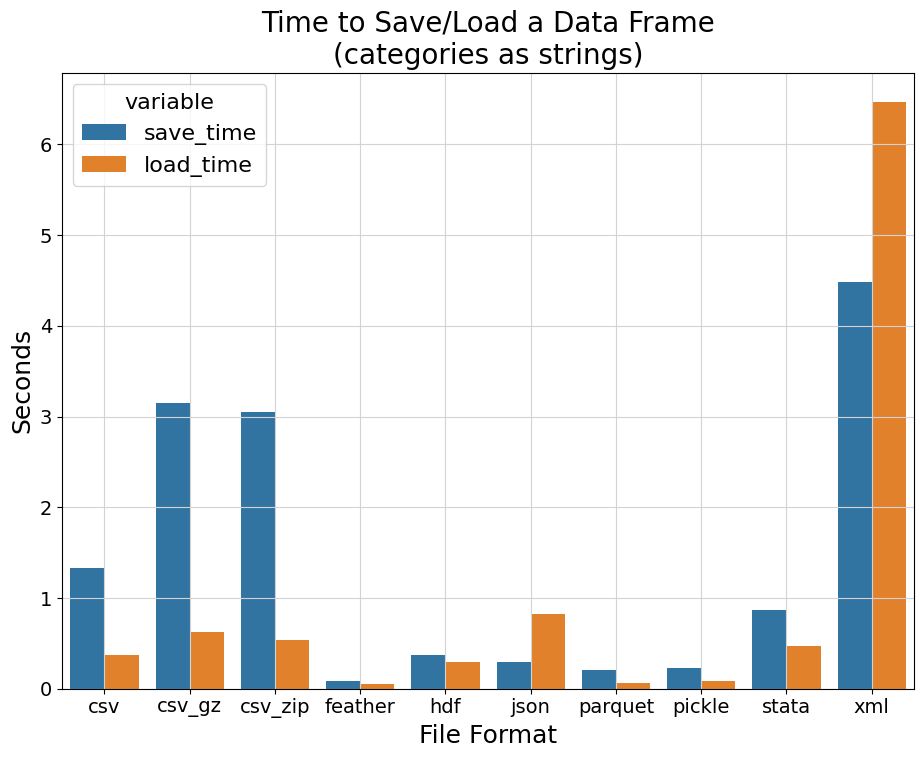

In [47]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as strings)')
ax.grid(True)